# Xarray Interpolation, Groupby, Resample, Rolling, and Coarsen

In this lesson, we cover some more advanced aspects of xarray.

In [8]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%xmode Minimal

Exception reporting mode: Minimal


## Interpolation

In the previous lesson on Xarray, we learned how to select data based on its dimension coordinates and align data with dimension different coordinates.
But what if we want to estimate the value of the data variables at _different coordinates_.
This is where interpolation comes in.

In [2]:
# we write it out explicitly so we can see each point.
x_data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
f = xr.DataArray(x_data**2, dims=['x'], coords={'x': x_data})
f

<xarray.DataArray (x: 11)> Size: 88B
array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100])
Coordinates:
  * x        (x) int64 88B 0 1 2 3 4 5 6 7 8 9 10

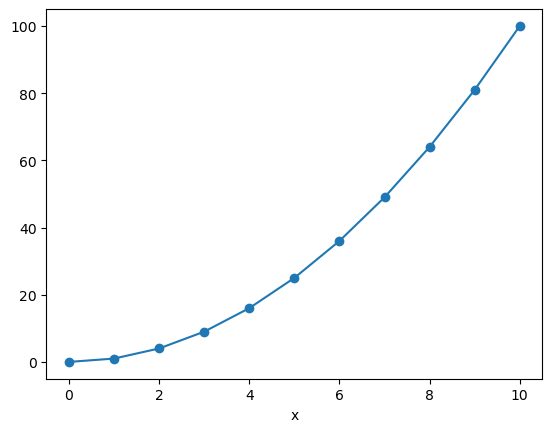

In [3]:
f.plot(marker='o')

We only have data on the integer points in x.
But what if we wanted to estimate the value at, say, 4.5?

In [4]:
f.sel(x=4.5)

KeyError: "not all values found in index 'x'. Try setting the `method` keyword argument (example: method='nearest')."

Interpolation to the rescue!

In [5]:
f.interp(x=4.5)

<xarray.DataArray ()>
array(20.5)
Coordinates:
    x        float64 4.5

Interpolation uses [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) under the hood.
There are different modes of interpolation.

In [6]:
# default
f.interp(x=4.5, method='linear').values

array(20.5)

In [7]:
f.interp(x=4.5, method='nearest').values

array(16.)

In [8]:
f.interp(x=4.5, method='cubic').values

array(20.25)

We can interpolate to a whole new coordinate at once:

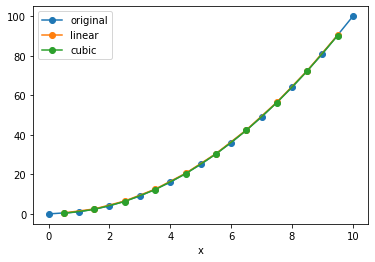

In [9]:
x_new = x_data + 0.5
f_interp_linear = f.interp(x=x_new, method='linear')
f_interp_cubic = f.interp(x=x_new, method='cubic')
f.plot(marker='o', label='original')
f_interp_linear.plot(marker='o', label='linear')
f_interp_cubic.plot(marker='o', label='cubic')
plt.legend()

Note that values outside of the original range are not supported:

In [10]:
f_interp_linear.values

array([ 0.5,  2.5,  6.5, 12.5, 20.5, 30.5, 42.5, 56.5, 72.5, 90.5,  nan])

```{note}
You can apply interpolation to any dimension, and even to multiple dimensions at a time.
(Multidimensional interpolation only supports `mode='nearest'` and `mode='linear'`.)
But keep in mind that _Xarray has no built-in understanding of geography_.
If you use `interp` on lat / lon coordinates, it will just perform naive interpolation of the lat / lon values.
More sophisticated treatment of spherical geometry requires another package such as [xesmf](https://xesmf.readthedocs.io/).
```

## Groupby

Xarray copies Pandas' very useful groupby functionality, enabling the "split / apply / combine" workflow on xarray DataArrays and Datasets. In the first part of the lesson, we will learn to use groupby by analyzing sea-surface temperature data.

First we load a dataset. We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) product, a widely used and trusted gridded compilation of of historical data going back to 1854.

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [10]:
# url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'

# url = 'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc'
# ds = xr.open_dataset(url, drop_variables=['time_bnds'])

ds = xr.open_dataset('data/sst.mnmean.nc', drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1960', '2018')).load()
ds

<xarray.Dataset> Size: 45MB
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 45MB -1.8 -1.8 -1.8 -1.8 ... nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-08-05

Let's do some basic visualizations of the data, just to make sure it looks reasonable.

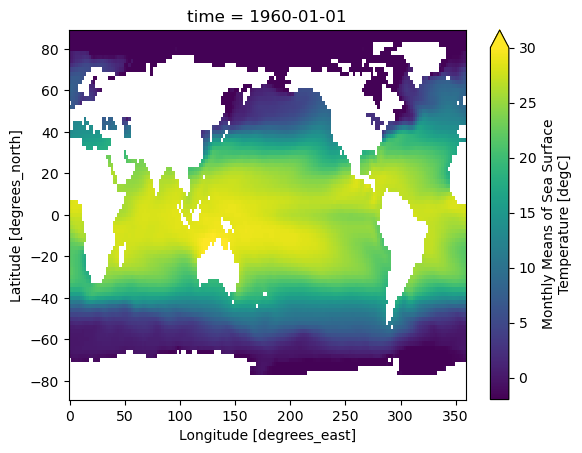

In [11]:
ds.sst[0].plot(vmin=-2, vmax=30)

Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [12]:
ds.time

<xarray.DataArray 'time' (time: 708)> Size: 6kB
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2018-10-01T00:00:00.000000000',
       '2018-11-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81996.]

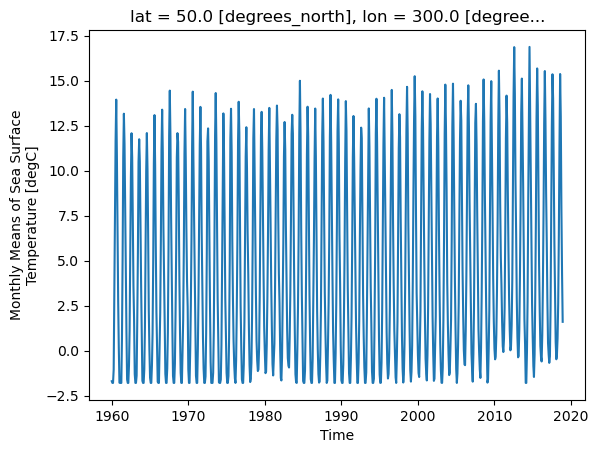

In [13]:
ds.sst.sel(lon=300, lat=50).plot()

As we can see from the plot, the timeseries at any one point is totally dominated by the seasonal cycle. We would like to remove this seasonal cycle (called the "climatology") in order to better see the long-term variaitions in temperature. We will accomplish this using **groupby**.

The syntax of Xarray's groupby is almost identical to Pandas.
We will first apply groupby to a single DataArray.

In [14]:
ds.sst.groupby?

Signature:
ds.sst.groupby(
    group: 'Hashable | DataArray | IndexVariable',
    squeeze: 'bool | None' = None,
    restore_coord_dims: 'bool' = False,
) -> 'DataArrayGroupBy'
Docstring:
Returns a DataArrayGroupBy object for performing grouped operations.

Parameters
----------
group : Hashable, DataArray or IndexVariable
    Array whose unique values should be used to group this array. If a
    Hashable, must be the name of a coordinate contained in this dataarray.
squeeze : bool, default: True
    If "group" is a dimension of any arrays in this dataset, `squeeze`
    controls whether the subarrays have a dimension of length 1 along
    that dimension or if the dimension is squeezed out.
restore_coord_dims : bool, default: False
    If True, also restore the dimension order of multi-dimensional
    coordinates.

Returns
-------
grouped : DataArrayGroupBy
    A `DataArrayGroupBy` object patterned after `pandas.GroupBy` that can be
    iterated over in the form of `(unique_value, group

### Split Step

The most important argument is `group`: this defines the unique values we will us to "split" the data for grouped analysis. We can pass either a DataArray or a name of a variable in the dataset. Lets first use a DataArray. Just like with Pandas, we can use the time indexe to extract specific components of dates and times. Xarray uses a special syntax for this `.dt`, called the `DatetimeAccessor`.

In [15]:
ds.time.dt

In [18]:
ds.time.dt.month

<xarray.DataArray 'month' (time: 708)> Size: 6kB
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81996.]

In [19]:
ds.time.dt.year

<xarray.DataArray 'year' (time: 708)> Size: 6kB
array([1960, 1960, 1960, ..., 2018, 2018, 2018])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81996.]

We can use these arrays in a groupby operation:

In [20]:
gb = ds.sst.groupby(ds.time.dt.month)
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Xarray also offers a more concise syntax when the variable you're grouping on is already present in the dataset. This is identical to the previous line:

In [21]:
gb = ds.sst.groupby('time.month')
gb

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now that the data are split, we can manually iterate over the group. The iterator returns the key (group name) and the value (the actual dataset corresponding to that group) for each group.

In [22]:
for group_name, group_da in gb:
    # stop iterating after the first loop
    break 
print(group_name)
group_da

1


<xarray.DataArray 'sst' (time: 59, lat: 89, lon: 180)> Size: 4MB
array([[[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
...
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 472B 1960-01-01 1961-01-01 ... 2018-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

### Map & Combine

Now that we have groups defined, it's time to "apply" a calculation to the group. Like in Pandas, these calculations can either be:
- _aggregation_: reduces the size of the group
- _transformation_: preserves the group's full size

At then end of the apply step, xarray will automatically combine the aggregated / transformed groups back into a single object.

```{warning}
Xarray calls the "apply" step `map`. This is different from Pandas!
```

The most fundamental way to apply is with the `.map` method.

In [21]:
gb.map?

Signature: gb.map(func, shortcut=False, args=(), **kwargs)
Docstring:
Apply a function to each array in the group and concatenate them
together into a new array.

`func` is called like `func(ar, *args, **kwargs)` for each array `ar`
in this group.

Apply uses heuristics (like `pandas.GroupBy.apply`) to figure out how
to stack together the array. The rule is:

1. If the dimension along which the group coordinate is defined is
   still in the first grouped array after applying `func`, then stack
   over this dimension.
2. Otherwise, stack over the new dimension given by name of this
   grouping (the argument to the `groupby` function).

Parameters
----------
func : callable
    Callable to apply to each array.
shortcut : bool, optional
    Whether or not to shortcut evaluation under the assumptions that:

    (1) The action of `func` does not depend on any of the array
        metadata (attributes or coordinates) but only on the data and
        dimensions.
    (2) The action of `func` c

#### Aggregations

`.apply` accepts as its argument a function. We can pass an existing function:

In [23]:
gb.map(np.mean)

<xarray.DataArray 'sst' (month: 12)> Size: 48B
array([13.659755 , 13.768756 , 13.764999 , 13.6841545, 13.642284 ,
       13.712899 , 13.9219055, 14.094026 , 13.982295 , 13.691284 ,
       13.506605 , 13.529584 ], dtype=float32)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Because we specified no extra arguments (like `axis`) the function was applied over all space and time dimensions. This is not what we wanted. Instead, we could define a custom function. This function takes a single argument--the group dataset--and returns a new dataset to be combined:

In [23]:
def time_mean(a):
    return a.mean(dim='time')

gb.apply(time_mean)

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
array([[[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7995025, -1.7995973, -1.7998415, ..., -1.7997988,
         -1.7996519, -1.7995045],
        [-1.7995876, -1.7997634, -1.8000009, ..., -1.8000009,
         -1.7998358, -1.7996247],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Like Pandas, xarray's groupby object has many built-in aggregation operations (e.g. `mean`, `min`, `max`, `std`, etc):

In [24]:
# this does the same thing as the previous cell
sst_mm = gb.mean(dim='time')
sst_mm

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)> Size: 769kB
array([[[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[-1.7995427, -1.7996352, -1.7998595, ..., -1.7997919,
         -1.7996687, -1.7995385],
        [-1.7995995, -1.7997794, -1.8000009, ..., -1.8000009,
         -1.7998233, -1.7996242],
        [-1.8000009, -1.8000009, -1.8000009, ..., -1.8000009,
         -1.8000009, -1.8000009],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

So we did what we wanted to do: calculate the climatology at every point in the dataset. Let's look at the data a bit.

_Climatlogy at a specific point in the North Atlantic_

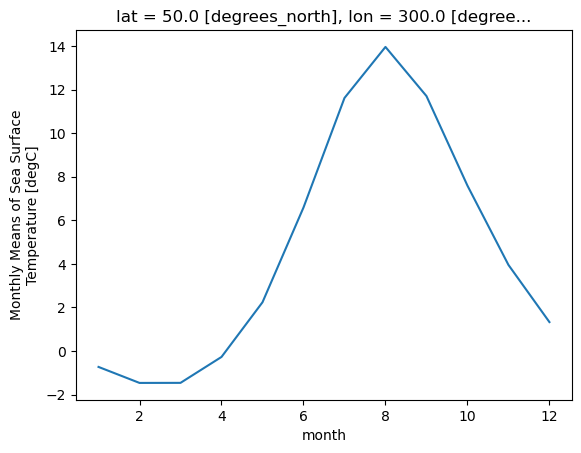

In [25]:
sst_mm.sel(lon=300, lat=50).plot()

_Zonal Mean Climatolgoy_

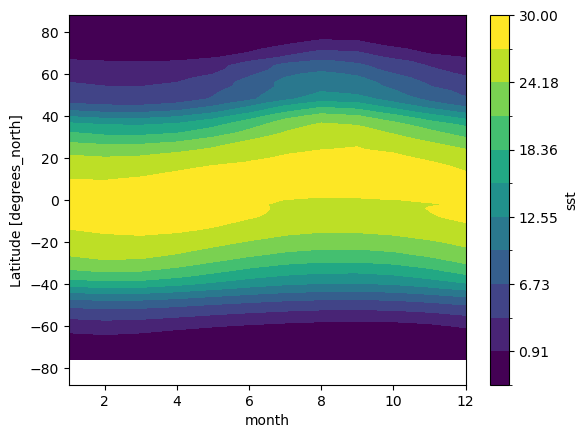

In [26]:
sst_mm.mean(dim='lon').transpose().plot.contourf(levels=12, vmin=-2, vmax=30)

_Difference between January and July Climatology_

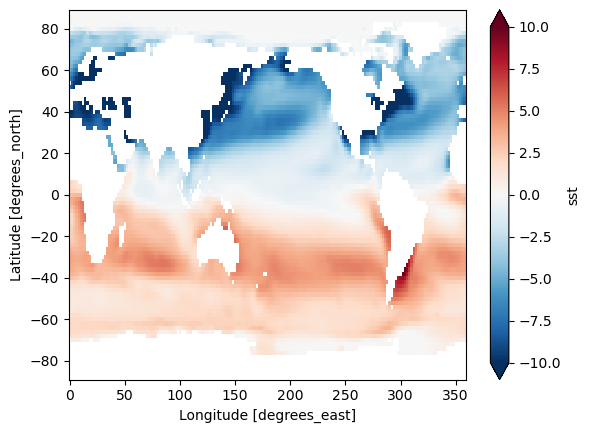

In [27]:
(sst_mm.sel(month=1) - sst_mm.sel(month=7)).plot(vmax=10)

#### Transformations

Now we want to _remove_ this climatology from the dataset, to examine the residual, called the _anomaly_, which is the interesting part from a climate perspective.
Removing the seasonal climatology is a perfect example of a transformation: it operates over a group, but doesn't change the size of the dataset. Here is one way to code it.

In [28]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

ds_anom = ds.groupby('time.month').apply(remove_time_mean)
ds_anom

<xarray.Dataset> Size: 45MB
Dimensions:  (time: 708, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
Data variables:
    sst      (time, lat, lon) float32 45MB 9.537e-07 9.537e-07 ... nan nan

```{note}
In the above example, we applied `groupby` to a `Dataset` instead of a `DataArray`.
```

Xarray makes these sorts of transformations easy by supporting _groupby arithmetic_.
This concept is easiest explained with an example:

In [45]:
gb = ds.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
ds_anom

# sstm = gb.mean(dim='time')
# sstm.sst[:,40,100].plot()

<xarray.Dataset> Size: 45MB
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 45MB 9.537e-07 9.537e-07 ... nan nan

Now we can view the climate signal without the overwhelming influence of the seasonal cycle.

_Timeseries at a single point in the North Atlantic_

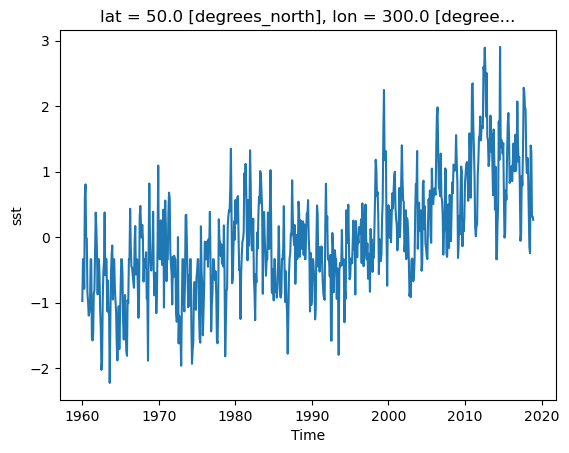

In [46]:
ds_anom.sst.sel(lon=300, lat=50).plot()

_Difference between Jan. 1 2018 and Jan. 1 1960_

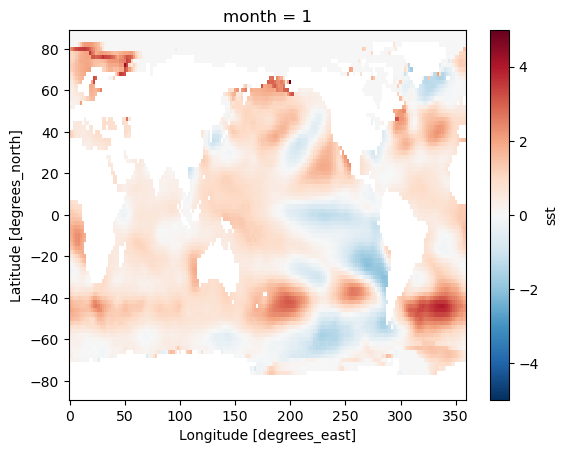

In [47]:
(ds_anom.sel(time='2018-01-01') - ds_anom.sel(time='1960-01-01')).sst.plot()

## Grouby-Related: Resample, Rolling, Coarsen


### Resample

Resample in xarray is nearly identical to Pandas.
**It can be applied only to time-index dimensions.** Here we compute the five-year mean.
It is effectively a group-by operation, and uses the same basic syntax.
Note that resampling changes the length of the the output arrays.

In [32]:
ds_anom_resample = ds_anom.resample(time='5Y').mean(dim='time')
ds_anom_resample

<xarray.Dataset>
Dimensions:  (time: 13, lat: 89, lon: 180)
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1965-12-31 ... 2020-12-31
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lat, lon) float32 -0.0005707 -0.0005493 ... nan nan

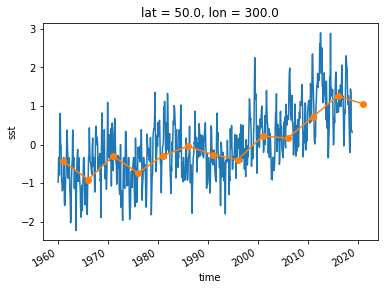

In [33]:
ds_anom.sst.sel(lon=300, lat=50).plot()
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o')

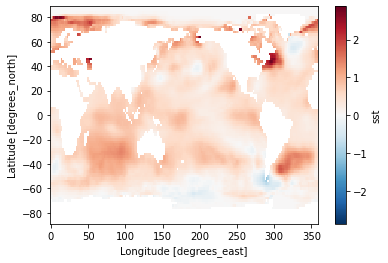

In [34]:
(ds_anom_resample.sel(time='2015-01-01', method='nearest') -
 ds_anom_resample.sel(time='1965-01-01', method='nearest')).sst.plot()

### Rolling

Rolling is also similar to pandas.
It does not change the length of the arrays.
Instead, it allows a moving window to be applied to the data at each point.

In [35]:
ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()
ds_anom_rolling

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 708)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

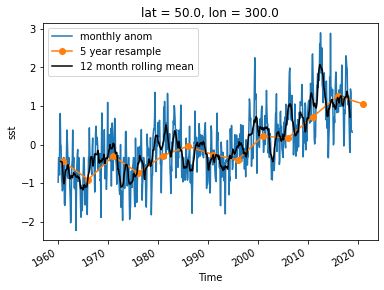

In [36]:
ds_anom.sst.sel(lon=300, lat=50).plot(label='monthly anom')
ds_anom_resample.sst.sel(lon=300, lat=50).plot(marker='o', label='5 year resample')
ds_anom_rolling.sst.sel(lon=300, lat=50).plot(label='12 month rolling mean', color='k')
plt.legend()

## Coarsen

`coarsen` is a simple way to reduce the size of your data along one or more axes.
It is very similar to `resample` when operating on time dimensions; the key difference is that `coarsen` only operates on fixed blocks of data, irrespective of the coordinate values, while `resample` actually looks at the coordinates to figure out, e.g. what month a particular data point is in. 

For regularly-spaced monthly data beginning in January, the following should be equivalent to annual resampling.
However, results would different for irregularly-spaced data.

In [37]:
ds.coarsen(time=12).mean()

<xarray.Dataset>
Dimensions:  (time: 59, lat: 89, lon: 180)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-06-16T08:00:00 ... 2018-06-16T12:00:00
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2021-11-07
    DODS_EXTRA.Unlimited_Dimension:  time

Coarsen also works on spatial coordinates (or any coordiantes).

## Masking Data

Masking of data can be performed in Xarray by providing single or multiple conditions to either Xarray’s `.where()` method or a Dataset or DataArray’s `.where()` method. Data values matching the condition(s) are converted into a single example value, effectively masking them from the scientifically important data. In the following set of examples, we use the .where() method to mask various data values in the `ds_anom` DataArray.

For reference, we will first print our previously calculated sea surface temperature anomaly dataset:

In [57]:
ds_anom.sst

<xarray.DataArray 'sst' (time: 708, lat: 89, lon: 180)> Size: 45MB
array([[[ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.5728683e-04, -3.6478043e-04, -1.4042854e-04, ...,
         -2.0802021e-04, -3.3128262e-04, -4.6145916e-04],
        [-4.0042400e-04, -2.2053719e-04,  9.5367432e-07, ...,
          9.5367432e-07, -1.7666817e-04, -3.7574768e-04],
        [ 9.5367432e-07,  9.5367432e-07,  9.5367432e-07, ...,
          9.5367432e-07,  9.5367432e-07,  9.5367432e-07],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 6kB 1960-01-01 1960-02-01 ... 2018-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

`.where()` preserves the shape of the original data by masking the values with a Boolean condition. Data values for which the condition is True are returned identical to the values passed in. On the other hand, data values for which the condition is False are returned as a preset example value. (This example value defaults to nan, but can be set to other values as well.)

In the following example, we make use of `.where()` to mask data with temperature values greater than 0. Therefore, values greater than 0 are set to nan, as described above. (It is important to note that the Boolean condition matches values to keep, not values to mask out.)

In [67]:
sample = ds_anom.sst.sel(time='1997-12-01')

masked_sample = sample.where(sample < 0.0)

masked_sample

<xarray.DataArray 'sst' (lat: 89, lon: 180)> Size: 64kB
array([[-0.00045729, -0.00036478, -0.00014043, ..., -0.00020802,
        -0.00033128, -0.00046146],
       [-0.00040042, -0.00022054,         nan, ...,         nan,
        -0.00017667, -0.00037575],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    time     datetime64[ns] 8B 1997-12-01
    month    int64 8B 12

We use Matplotlib to plot the original, unmasked data, as well as the masked data created in the previous example.

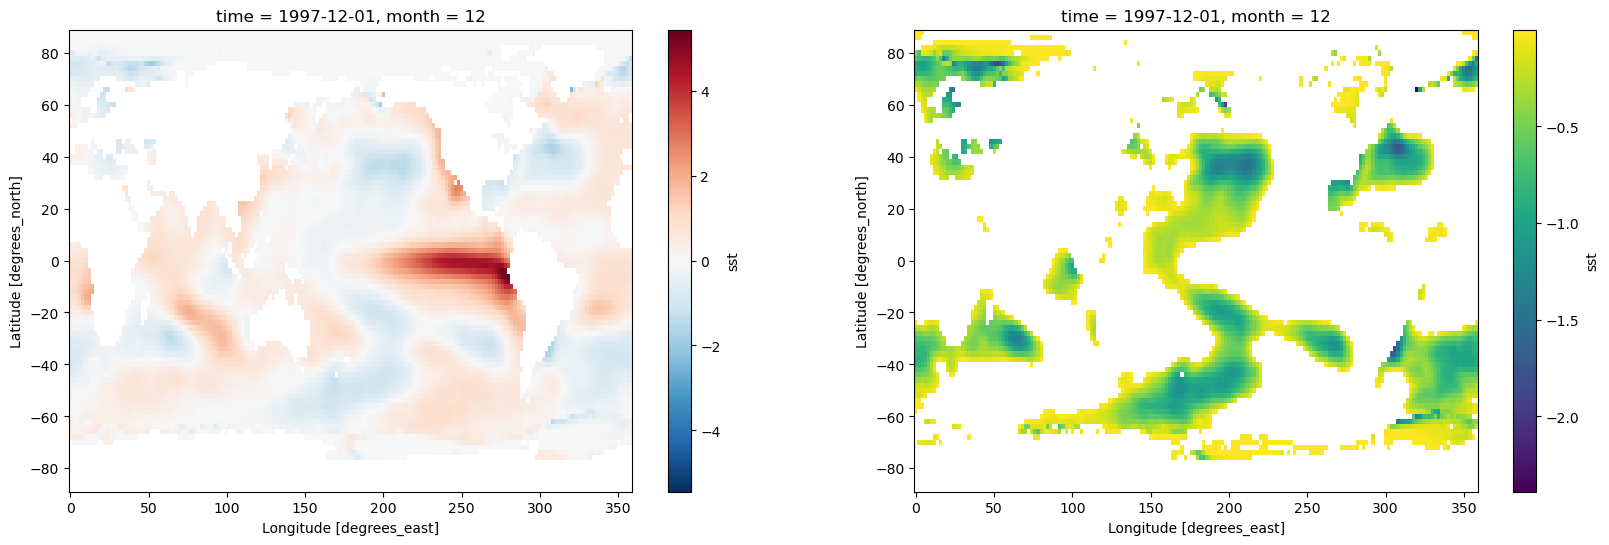

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
sample.plot(ax=axes[0])
masked_sample.plot(ax=axes[1])

We can also use `.where()` with multiple conditions:

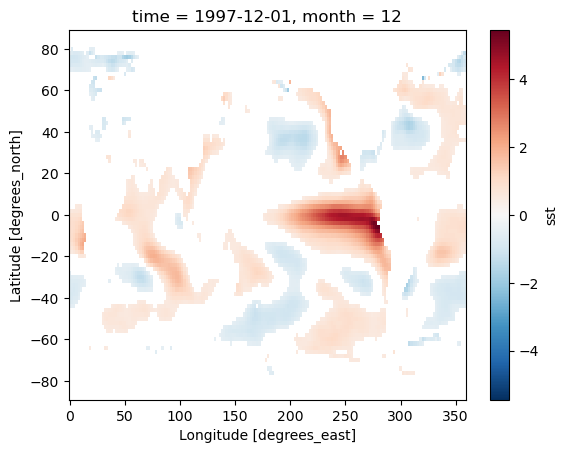

In [84]:
sample.where((sample > 0.5) | (sample < -0.5)).plot()

Masked data values can also be set to values other than nan by providing a second value (for example, 0 in the following) to the `.where()` method:

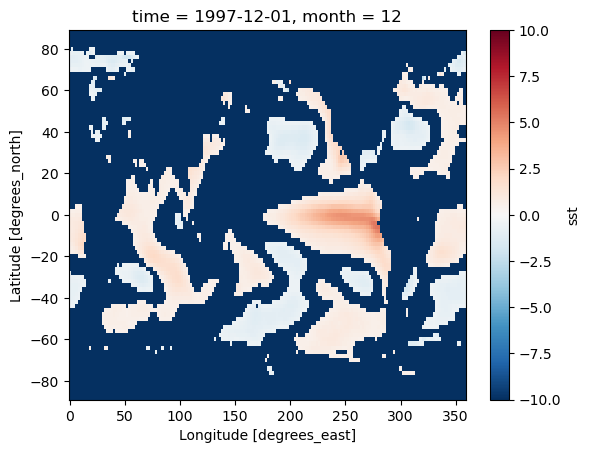

In [90]:
sample.where((sample > 0.5) | (sample < -0.5), -10).plot()

We can also mask regions outside of the Niño 3.4 region:

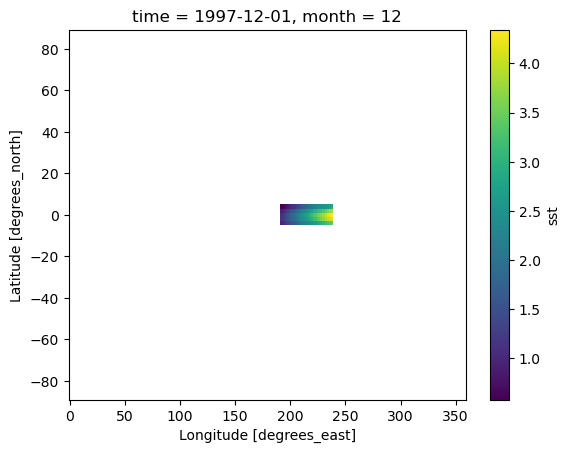

In [86]:
sample.where(
    (sample.lat < 5) & (sample.lat > -5) & (sample.lon > 190) & (sample.lon < 240)
).plot()

## An Advanced Example

In this example we will show a realistic workflow with Xarray.
We will
- Load a "basin mask" dataset
- Interpolate the basins to our SST dataset coordinates
- Group the SST by basin
- Convert to Pandas Dataframe and plot mean SST by basin

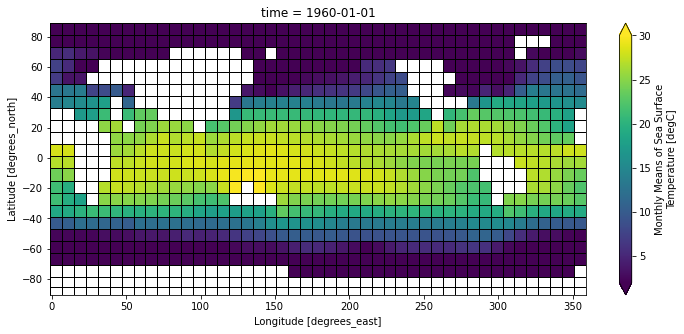

In [38]:
ds_coarse = ds.coarsen(lon=4, lat=4, boundary='pad').mean()
ds_coarse.sst.isel(time=0).plot(vmin=2, vmax=30, figsize=(12, 5), edgecolor='k')

In [48]:
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin

<xarray.Dataset> Size: 9MB
Dimensions:  (X: 360, Y: 180, Z: 33)
Coordinates:
  * X        (X) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * Y        (Y) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 132B 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, Y, X) float32 9MB ...
Attributes:
    Conventions:  IRIDL

In [49]:
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin

<xarray.Dataset> Size: 9MB
Dimensions:  (lon: 360, lat: 180, Z: 33)
Coordinates:
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * Z        (Z) float32 132B 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    basin    (Z, lat, lon) float32 9MB ...
Attributes:
    Conventions:  IRIDL

In [50]:
basin_surf = basin.basin[0]
basin_surf

<xarray.DataArray 'basin' (lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    Z        float32 4B 0.0
Attributes:
    long_name:  basin code
    CLIST:      Atlantic Ocean\nPacific Ocean \nIndian Ocean\nMediterranean S...
    valid_min:  1
    valid_max:  58
    scale_min:  1
    units:      ids
    scale_max:  58

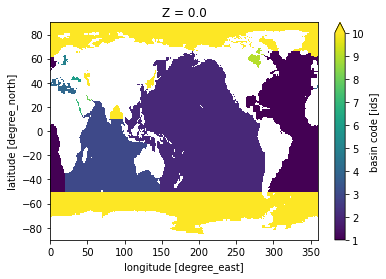

In [42]:
basin_surf.plot(vmax=10)

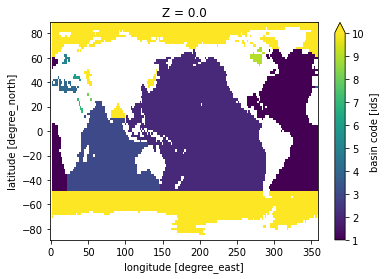

In [43]:
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
basin_surf_interp.plot(vmax=10)

In [44]:
ds.sst.groupby(basin_surf_interp).first()

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[-1.8       , -1.8       , 23.455315  , ..., -1.8       ,
         3.3971915 , 24.182198  ],
       [-1.8       , -1.8       , 23.722523  , ..., -1.8       ,
         0.03573781, 24.59657   ],
       [-1.8       , -1.8       , 24.601315  , ..., -1.8       ,
        -0.26487017, 26.234186  ],
       ...,
       [ 0.6758132 ,  6.504184  , 29.279463  , ..., 10.920228  ,
        15.955025  , 29.41976   ],
       [-0.7937442 ,  3.0715032 , 27.608435  , ...,  5.4078875 ,
        10.673693  , 27.7558    ],
       [-1.8       , -0.06063586, 25.881481  , ...,  0.5253569 ,
         7.267694  , 26.163145  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [45]:
basin_mean_sst = ds.sst.groupby(basin_surf_interp).mean()
basin_mean_sst

<xarray.DataArray 'sst' (time: 708, basin: 14)>
array([[18.585493 , 20.757555 , 21.572067 , ...,  6.238062 ,  6.889794 ,
        26.49982  ],
       [18.705065 , 20.81674  , 21.902279 , ...,  4.8877654,  5.44638  ,
        26.577093 ],
       [18.845842 , 20.865038 , 22.031416 , ...,  4.686406 ,  5.5322194,
        27.908558 ],
       ...,
       [19.84992  , 21.960493 , 20.389412 , ..., 17.571943 , 18.184528 ,
        29.336565 ],
       [19.424026 , 21.722925 , 21.061403 , ..., 13.461868 , 13.863244 ,
        28.755905 ],
       [19.265354 , 21.512274 , 21.814356 , ...,  9.417906 , 10.607256 ,
        27.905243 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2018-12-01
    Z        float32 0.0
  * basin    (basin) float64 1.0 2.0 3.0 4.0 5.0 ... 10.0 11.0 12.0 53.0 56.0

In [46]:
df = basin_mean_sst.mean('time').to_dataframe()
df

,Z,sst
basin,,
1.0,0.0,19.284992
2.0,0.0,21.178225
3.0,0.0,21.127054
4.0,0.0,19.845881
5.0,0.0,8.131749
6.0,0.0,15.084384
7.0,0.0,28.494108
8.0,0.0,26.619698
9.0,0.0,0.310854


In [47]:
import pandas as pd
basin_names = basin_surf.attrs['CLIST'].split('\n')
basin_df = pd.Series(basin_names, index=np.arange(1, len(basin_names)+1))
basin_df

1                 Atlantic Ocean
2                 Pacific Ocean 
3                   Indian Ocean
4              Mediterranean Sea
5                     Baltic Sea
6                      Black Sea
7                        Red Sea
8                   Persian Gulf
9                     Hudson Bay
10                Southern Ocean
11                  Arctic Ocean
12                  Sea of Japan
13                      Kara Sea
14                      Sulu Sea
15                    Baffin Bay
16            East Mediterranean
17            West Mediterranean
18                Sea of Okhotsk
19                     Banda Sea
20                 Caribbean Sea
21                 Andaman Basin
22               North Caribbean
23                Gulf of Mexico
24                  Beaufort Sea
25               South China Sea
26                   Barents Sea
27                   Celebes Sea
28                Aleutian Basin
29                    Fiji Basin
30          North American Basin
31        

In [48]:
df = df.join(basin_df.rename('basin_name'))

<AxesSubplot:xlabel='basin_name'>

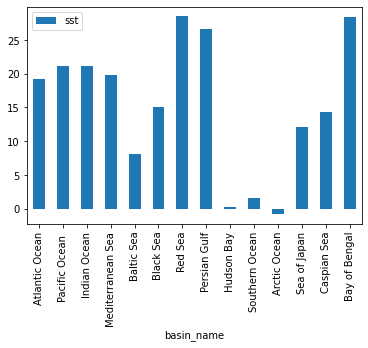

In [49]:
df.plot.bar(y='sst', x='basin_name')